# Solar Dynamo

In [1]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Turing
using Distributions
using SimulatedAnnealingABC
using DataFrames
using Random
using Distances

In [7]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

df = DataFrame(
    year = Int[],
    open_magn_flux = Float64[],
    open_magn_flux_err = Float64[],
    ssa_open_magn_flux = Float64[],
    sunspots_num = Float64[],
    sunspots_err = Float64[],
    ssa_sunspots = Float64[]
)

# Apri il file e leggi i dati
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
    sheet = file["Data"] 

    for row in XLSX.eachrow(sheet)
        if isa(row[2], Number)
            push!(df, (
                year = row[2],
                open_magn_flux = row[3],
                open_magn_flux_err = row[4],
                ssa_open_magn_flux = row[5],
                sunspots_num = row[7],
                sunspots_err = row[8],
                ssa_sunspots = row[9]
            ))
        end
    end
end


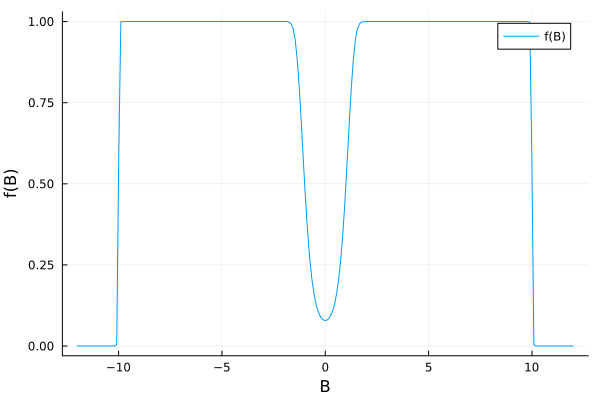

In [3]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE 

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

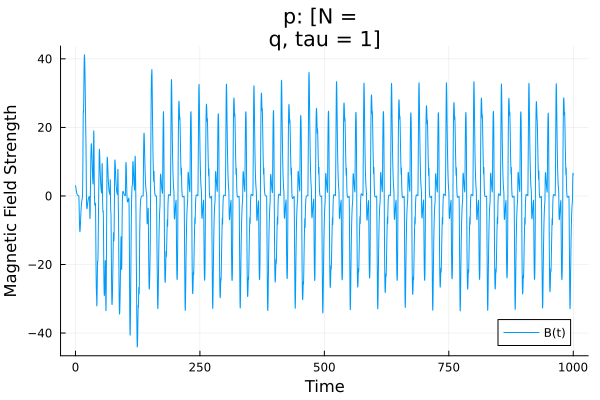

In [4]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = 8.4
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
N = 7.5875
q = 6.7050
p = [N, q, tau]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 1000)
h(p, t) = [0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, p)
sol = solve(prob, MethodOfSteps(Tsit5()), saveat = 0.01)

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = 
q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

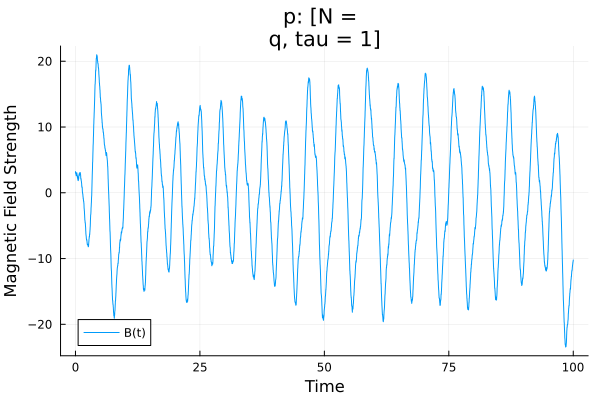

In [5]:
# SDDE PROBLEM WITHOUT PERIODIC MODULATION

# Define parameters
N = 8.4
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
sigma = 0.1
params = [N, q, tau, sigma, B_max]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 100)
h(p, t) = [0.0, 0.0]

# Define noise initial conditions
noise0 = [1.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau, sigma, Bmax = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

function noise(du, u, h, p, t)
  N, q, tau, sigma, Bmax = p
  du[1] = (sigma * Bmax)
end

# Define and solve the SDDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.01)

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = 
q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

In [70]:

# Set up the DDE problem
p = [0.1, 1.0, 2.0, 0.05, 1.0]  # Parameters N, q, tau, sigma, Bmax
tspan = (0.0, 10.0)
u0 = [1.0, 0.0]  # Initial condition: [B, dB]

# Create a DDEProblem object
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
# Solve the DDE using a suitable method
sol = solve(prob, EM(), dt = 0.02)
# Generate observational data (this would be replaced with real data)
observed_data = sol[1,:]  # Add noise
mean_obs = mean(observed_data)
std_obs = std(observed_data)
ss_obs=[mean_obs, std_obs]

# Define prior distributions for the parameters
prior = product_distribution(Uniform(0, 1), Uniform(0.5, 2), Uniform(1, 3), Uniform(0.01, 0.1), Uniform(0.5, 2))
# Define a function to simulate data and calculate distance
function f_dist(x::Vector{Float64}; type::Int64 = 1)
    
    sol = solve(SDDEProblem(MagneticField, noise, B0, h, tspan, x), EM(), dt = 0.01)
    simulated_data = sol[1,:]

    # Compute summary statistics (e.g., mean and std)
    mean_sim = mean(simulated_data)
    std_sim = std(simulated_data)
    ss=[mean_sim, std_sim]

    rho = [euclidean(ss[i], ss_obs[i]) for i in 1:size(ss,1)]

    # Distance vector for ABC
    return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=50, n_simulation=20000, v=1.0, type=1)
display(result)

# Display the results
println("Estimated parameters: ", result)

┌ Info: Using threads: 1 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:192
┌ Info: Initializing population...
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:219
┌ Info: Initial resampling (δ = 0.1) - ESS = 49.6156892337062 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:258
┌ Info: Population with 50 particles initialised.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:280
┌ Info: Initial ϵ = [1.1583296703296702, 1.1841414364640883]
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:281
┌ Info: 2024-05-06T12:19:26.596 -- Starting population updates.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.

Approximate posterior sample with 50 particles:
  - simulations used: 20000
  - average transformed distance: 0.006102
  - ϵ: [0.000217, 0.0001356]
  - population resampling: 6
  - acceptance rate: 0.03398
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


Estimated parameters: Approximate posterior sample with 50 particles:
  - simulations used: 20000
  - average transformed distance: 0.006102
  - ϵ: [0.000217, 0.0001356]
  - population resampling: 6
  - acceptance rate: 0.03398
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 



In [75]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)


## Update existing population with another 1_000_000 simulations
v = 1.0   # v = 10 for multi-epsilon
# replace 'out' with out_singeps, out_multeps or out_hybrid
# choose the corresponding type for the algorithm
type = 1
update_population!(result, f_dist, prior; v = v, n_simulation = 10_000, type = type)
println(rho_singeps)

┌ Info: 2024-05-06T12:21:03.871 -- Starting population updates.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:327
┌ Info: 2024-05-06T12:21:08.192 -- Update 100 of 200 -- ETA: 00:00:04 
│  ϵ: [0.0001457, 0.0001261] 
│  mean transformed distance: 0.005287 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:472
┌ Info: Resampling 7 (δ = 0.1) - ESS = 49.34079804771282
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:459
┌ Info: 2024-05-06T12:21:12.013 -- Update 200 of 200 -- ETA: 00:00:00 
│  ϵ: [0.0001176, 9.397e-5] 
│  mean transformed distance: 0.004664 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:472
┌ Info: 2024-05-06T12:21:12.013  All particles have been updated 200 times.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\pa

[0.4494827130280076 0.41892321988082765 0.41726415067569667 0.41123230885334594 0.3514266073249535 0.32816016720433266 0.31406412822316915 0.3025211732767498 0.30975682312109787 0.315379262931554 0.3304814901601709 0.3130068456047578 0.3163022701455911 0.31474759984832107 0.30488290814563435 0.28738335340378646 0.29327762694292836 0.2879743534661252 0.2731307104663352 0.2511297387415466 0.2594335296858424 0.2718764393726736 0.2682018895741636 0.2560274124220776 0.26131865760803275 0.25839125818139075 0.25651063125899787 0.22994714680260223 0.23994064049649264 0.23325787168439874 0.22922049313741336 0.22127262436580253 0.2403422518147473 0.21801519266143252 0.22240441741599967 0.21714365619249057 0.21069034819772192 0.21292415125052147 0.20891619160607988 0.20524849574095683 0.19451040802562186 0.18369147992863882 0.17789869483400422 0.16628863949051553 0.14824859702777318 0.15033827464705854 0.14139909988556315 0.13138270691332715 0.13921455052366624 0.13921455052366624 0.1421858870662

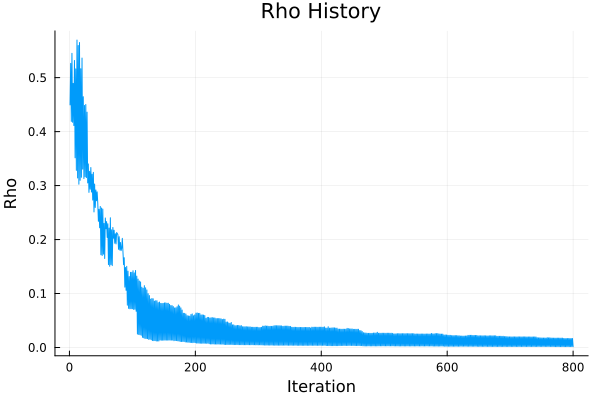

In [77]:
rho_history = vec(rho_singeps)  # Assuming each ϵ update is stored as a column
plot(rho_history, title="Rho History", xlabel="Iteration", ylabel="Rho", legend=false)

In [59]:
# Extract parameter samples for each parameter
param_samples = transpose(result.population)  # transpose to make each column represent a parameter
println("Valori di N:")
for value in param_samples[:,1]
    println(value)
end

println("\nValori di q:")
for value in param_samples[:,2]
    println(value)
end

println("\nValori di tau:")
for value in param_samples[:,3]
    println(value)
end

println("\nValori di sigma:")
for value in param_samples[:,4]
    println(value)
end

println("\nValori di Bmax:")
for value in param_samples[:,5]
    println(value)
end

Valori di N:
[0.05880477439900911 1.809350234823779 1.9443960708242796 0.03558957409370579 1.5221132013567944]

Valori di q:
[0.7387561706708068 1.9191311862944649 2.9186415294608565 0.06075122612481998 0.7769212888129433]

Valori di tau:
[0.24922031814565393 0.9269831486917328 1.1808746593278647 0.04628104530727408 1.1480843671723926]

Valori di sigma:
[0.7391480214614539 1.3534544530755486 1.5308264282077682 0.08253244938988924 1.1420008705544038]

Valori di Bmax:
[0.24002549072485665 1.9777537632628583 1.4731334260235038 0.03220070992823208 1.727611608446024]


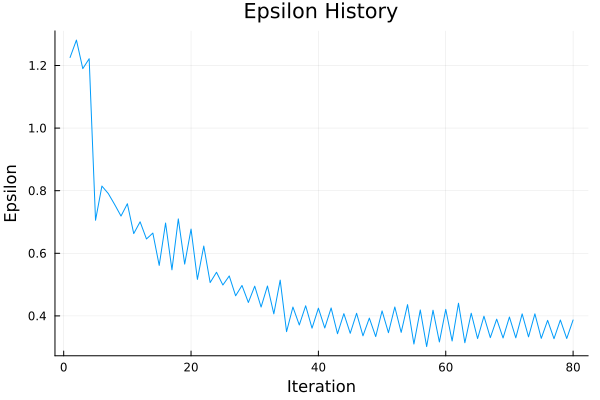

In [14]:
eps_history = vec(hcat(result.state.ϵ_history...))  # Assuming each ϵ update is stored as a column
plot(eps_history, title="Epsilon History", xlabel="Iteration", ylabel="Epsilon", legend=false)

In [36]:
Random.seed!()
true_mean = 3; true_sigma = 15
num_samples = 100
yobs = rand(Normal(true_mean, true_sigma), num_samples)
# ----------------- #

## Summary stats for obsrevations
# ----------------- #
s1obs = mean(yobs); s2obs = std(yobs) 
ss_obs = [s1obs, s2obs]
# ----------------- #

## Define prior
# ----------------- #
s1_min = -10; s1_max = 20    # stat 1 (distribution mean)
s2_min = 0; s2_max = 25      # stat 2 (distribution std)
prior = product_distribution(Uniform(s1_min, s1_max), Uniform(s2_min, s2_max))
# ----------------- #

## Model + distance function
## N.B.: DISTANCE MUST BE A VECTOR CONTAINING INDIVIDUAL DISTANCES FOR EACH STAT
# ----------------- #
function f_dist(θ)
	
	# Data-generating model
	y = rand(Normal(θ[1],θ[2]), num_samples)
	# Summary stats
	s1 = mean(y); s2 = std(y)
	ss = [s1, s2]
	# DistancE
	rho = [euclidean(ss[ix], ss_obs[ix]) for ix in 1:size(ss,1)]
	return rho
end
# ----------------- #

## Sample Posterior
# ----------------- #
nsim = 2_000_000  # total number of particle updates
# --- TYPE 1 -> single-epsilon ---
out_singeps = sabc(f_dist, prior; n_particles = 1000, v = 1.0, n_simulation = nsim, type = 1)
display(out_singeps)


## Extract posterior population, trajectories for epsilon, rho and u
# ----------------- #
pop_singeps = hcat(out_singeps.population...)
eps_singeps = hcat(out_singeps.state.ϵ_history...)
rho_singeps = hcat(out_singeps.state.ρ_history...)
u_singeps = hcat(out_singeps.state.u_history...)


┌ Info: Using threads: 1 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:192
┌ Info: Initializing population...
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:219
┌ Info: Initial resampling (δ = 0.1) - ESS = 993.6208806632895 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:258
┌ Info: Population with 1000 particles initialised.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:280
┌ Info: Initial ϵ = [1.151007070865309, 1.1564030495605087]
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:281
┌ Info: 2024-05-06T11:40:00.643 -- Starting population updates.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingAB

Approximate posterior sample with 1000 particles:
  - simulations used: 2000000
  - average transformed distance: 0.003457
  - ϵ: [6.491e-5, 5.202e-5]
  - population resampling: 8
  - acceptance rate: 0.008381
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


2×2000 Matrix{Float64}:
 0.481198  0.481434  0.46406   …  0.0031618   0.0031618   0.0031618
 0.479513  0.454882  0.443198     0.00375226  0.00375226  0.00375226